In [49]:
# take the model and test 5 images in in validation set

import torch
from utils.load_data import BrainDataset
from torch.utils.data import Dataset, DataLoader
from architecture.model import load_trained_model, All_view, evaluate_dice_scores, class_dice, arrange_img, dice_coef, mean_iou
import random


device = torch.device("mps")

In [50]:
# get data
train_data = r"../data"
val_dataset = BrainDataset(train_data, "val")
val_loader = DataLoader(val_dataset, batch_size=16)

In [51]:
from architecture.shared_model import DLUNet, ReASPP3, load_trained_model
import torch

# 1. First create a fresh model instance
model = load_trained_model(
    # "../mlruns/820203924686178493/40d84b246dd1475a93e8fb5c244ae452/artifacts/checkpoints/dlu_net_model_epoch_15.pth"
    "../mlruns/820203924686178493/3f3f50dcc84a40efa3665e02a104d67f/artifacts/checkpoints/dlu_net_model_epoch_40.pth"
)
# 5. Set model to evaluation mode
model.eval()
print("Model loaded successfully and set to evaluation mode")

Model loaded successfully and set to evaluation mode


In [52]:
# # model = load_trained_model("./model/dlu_net_model_epoch_20.pth")
# model = load_trained_model(
#     # "./model/dlu_net_model_epoch_52.pth"
#     # "./model/dlu_net_model_epoch_55.pth"
#     # "./model/dlu_net_model_epoch_68.pth"
#     "model/dlu_net_model_epoch_2.pth"

# )

# model.to(device)

In [53]:
print(val_loader.dataset)

Batch shape - Images: torch.Size([16, 4, 192, 192]), Masks: torch.Size([16, 5, 192, 192])
5
Sample Dice Scores - Tumor Core: 0.5508, Enhancing Tumor: 0.5428, Whole Tumor: 0.7803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


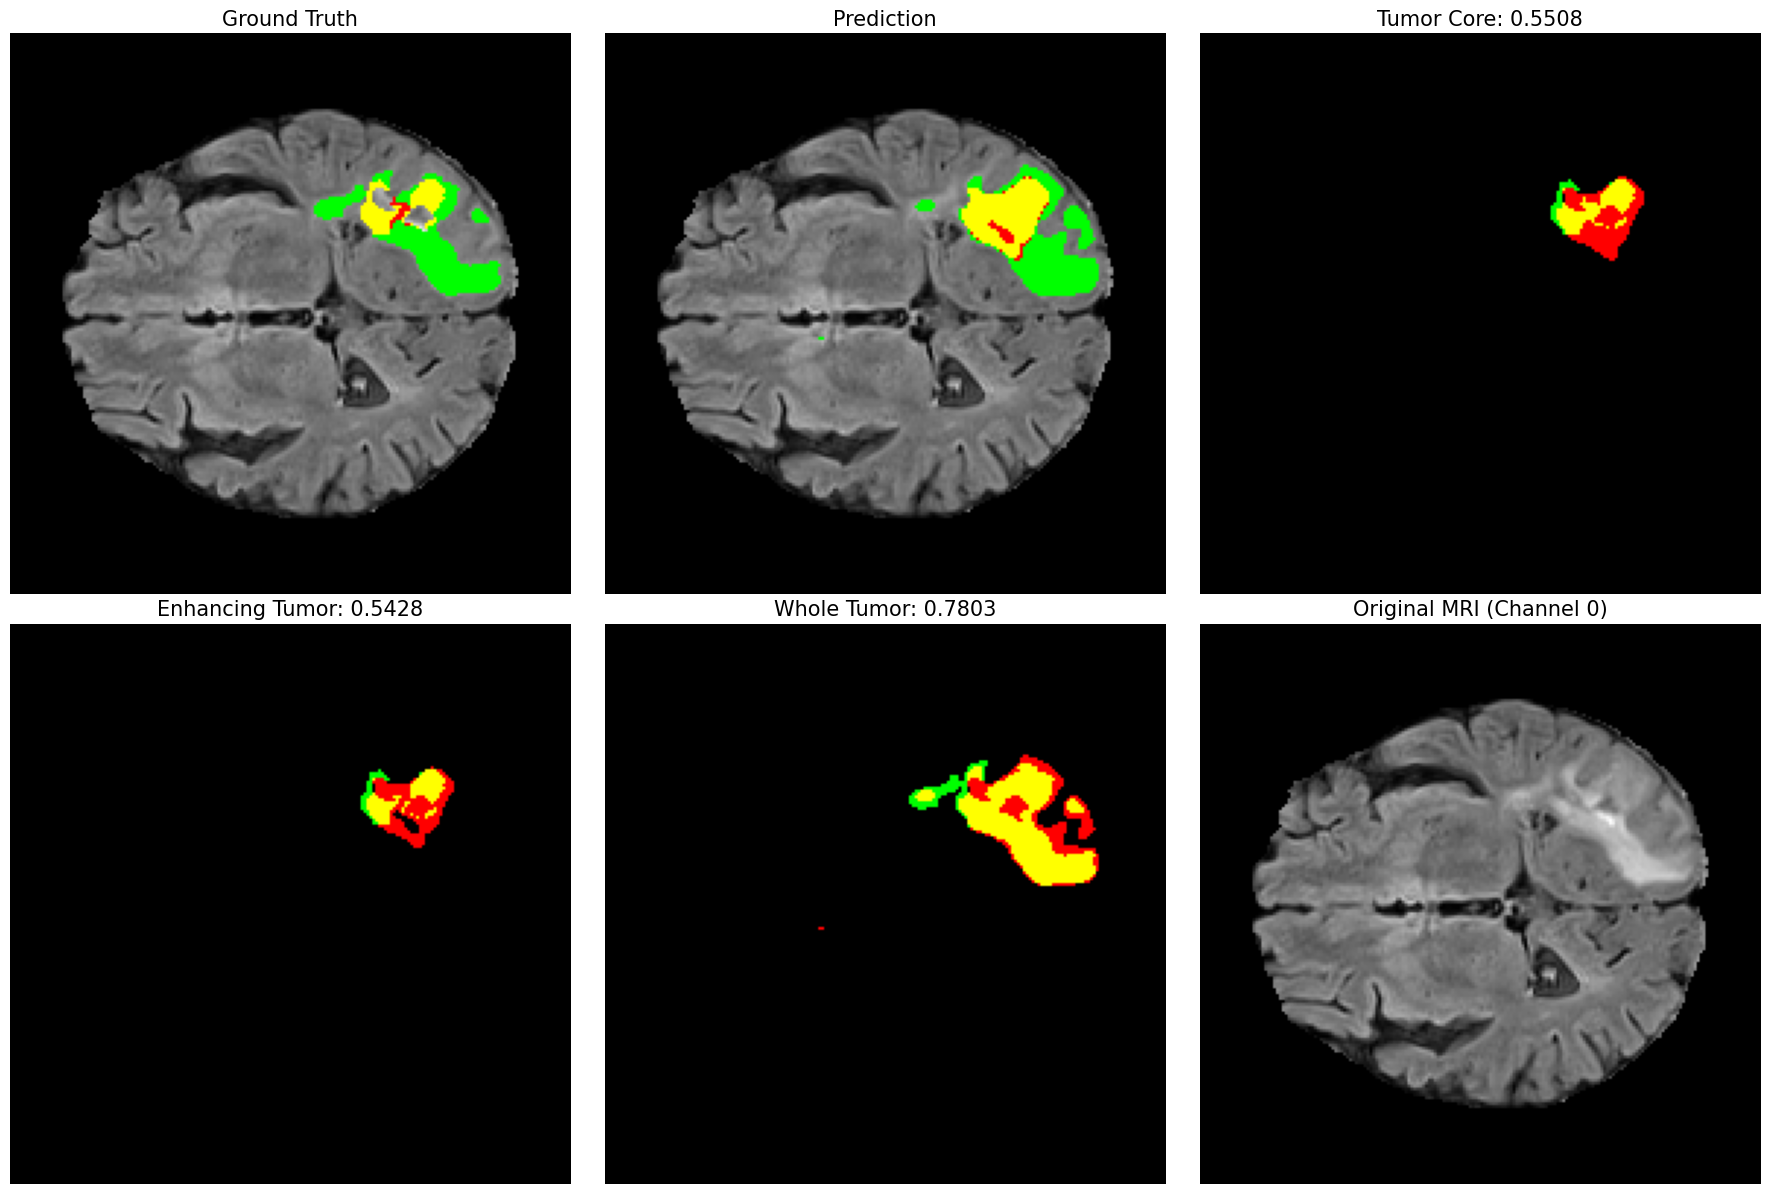

In [54]:
# Get a sample batch from the validation loader
# next() retrieves the first item from the iterator created by iter(val_loader)
# iter() creates an iterator from val_loader which is likely a DataLoader object
# This gets one batch of data containing both images and masks
import matplotlib.pyplot as plt
val_images, val_masks = next(iter(val_loader))
print(f"Batch shape - Images: {val_images.shape}, Masks: {val_masks.shape}")


# Select a random sample from the batch
random_idx = random.randint(0, val_images.shape[0]-1)


print(random_idx)


with torch.no_grad():
    # Get the first sample
    sample_image = val_images[random_idx:random_idx + 1].to(device)
    sample_mask = val_masks[random_idx:random_idx + 1].to(device)

    # Get prediction
    prediction = model(sample_image)
    thresholded_pred = (prediction > 0.2).float()

    # Use the prediction directly for dice calculation instead of calling evaluate_dice_scores
    tc_dice = class_dice(prediction, sample_mask, 2).item()
    ec_dice = class_dice(prediction, sample_mask, 3).item()
    wt_dice = class_dice(prediction, sample_mask, 4).item()

    print(
        f"Sample Dice Scores - Tumor Core: {tc_dice:.4f}, Enhancing Tumor: {ec_dice:.4f}, Whole Tumor: {wt_dice:.4f}")

# Visualize the prediction vs ground truth

# Convert tensors to the right format for visualization
sample_image_np = sample_image.cpu().numpy().transpose(
    0, 2, 3, 1)  # [B,C,H,W] -> [B,H,W,C]
sample_mask_np = sample_mask.cpu().numpy().transpose(0, 2, 3, 1)
pred_np = thresholded_pred.cpu().numpy().transpose(0, 2, 3, 1)

# Use the visualization functions
GT, Pre, TC, EC, WT = arrange_img(
    torch.from_numpy(sample_image_np),
    torch.from_numpy(sample_mask_np),
    torch.from_numpy(pred_np)
)

# Convert tensors to numpy for matplotlib if needed
if isinstance(GT, torch.Tensor):
    GT = GT.numpy()
if isinstance(Pre, torch.Tensor):
    Pre = Pre.numpy()
if isinstance(TC, torch.Tensor):
    TC = TC.numpy()
if isinstance(EC, torch.Tensor):
    EC = EC.numpy()
if isinstance(WT, torch.Tensor):
    WT = WT.numpy()

# Display the results
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax[0, 0].imshow(GT)
ax[0, 0].set_title('Ground Truth', fontsize=15)
ax[0, 0].axis("off")

ax[0, 1].imshow(Pre)
ax[0, 1].set_title('Prediction', fontsize=15)
ax[0, 1].axis("off")

ax[0, 2].imshow(TC)
ax[0, 2].set_title(f'Tumor Core: {tc_dice:.4f}', fontsize=15)
ax[0, 2].axis("off")

ax[1, 0].imshow(EC)
ax[1, 0].set_title(f'Enhancing Tumor: {ec_dice:.4f}', fontsize=15)
ax[1, 0].axis("off")

ax[1, 1].imshow(WT)
ax[1, 1].set_title(f'Whole Tumor: {wt_dice:.4f}', fontsize=15)
ax[1, 1].axis("off")

# Display original MRI (first channel)
ax[1, 2].imshow(sample_image_np[0, :, :, 0], cmap='gray')
ax[1, 2].set_title('Original MRI (Channel 0)', fontsize=15)
ax[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [55]:
# get average accuracy of the model for the entire validation set

import numpy as np
results = []

with torch.no_grad():

    for i in range(len(val_images)):
        # Get the first sample
        sample_image = val_images[i:i + 1].to(device)
        sample_mask = val_masks[i:i + 1].to(device)

        # Get prediction
        prediction = model(sample_image)
        thresholded_pred = (prediction > 0.2).float()

        # Use the prediction directly for dice calculation instead of calling evaluate_dice_scores
        tc_dice = class_dice(prediction, sample_mask, 2).item()
        ec_dice = class_dice(prediction, sample_mask, 3).item()
        wt_dice = class_dice(prediction, sample_mask, 4).item()

        dice_score_main = dice_coef(prediction, sample_mask)
        mean_iou_score = mean_iou(prediction, sample_mask)

        results.append([tc_dice, ec_dice, wt_dice,
                       dice_score_main, mean_iou_score])
    print(
        f"Sample Dice Scores - Tumor Core: {tc_dice:.4f}, Enhancing Tumor: {ec_dice:.4f}, Whole Tumor: {wt_dice:.4f}")

# get average of the results
print(results)
avg_tc_dice = sum([x[0] for x in results]) / len(results)
avg_ec_dice = sum([x[1] for x in results]) / len(results)
avg_wt_dice = sum([x[2] for x in results]) / len(results)
avg_dice_score_main = sum([x[3] for x in results]) / len(results)
avg_mean_iou = sum([x[4] for x in results]) / len(results)

print(
    f"Average Scores - Dice Score Main: {avg_dice_score_main:.4f}, Mean IoU: {avg_mean_iou:.4f}, Tumor Core: {avg_tc_dice:.4f}, Enhancing Tumor: {avg_ec_dice:.4f}, Whole Tumor: {avg_wt_dice:.4f}")

# # get the IQR of the results

tc_dice_values = [x[0] for x in results]
ec_dice_values = [x[1] for x in results]
wt_dice_values = [x[2] for x in results]
dice_score_main_values = [x[3] for x in results]
mean_iou_values = [x[4] for x in results]

print(
    f"IQR of Tumor Core Dice: {np.percentile(tc_dice_values, 75) - np.percentile(tc_dice_values, 25)}")
print(
    f"IQR of Enhancing Tumor Dice: {np.percentile(ec_dice_values, 75) - np.percentile(ec_dice_values, 25)}")
print(
    f"IQR of Whole Tumor Dice: {np.percentile(wt_dice_values, 75) - np.percentile(wt_dice_values, 25)}")

Sample Dice Scores - Tumor Core: 0.0017, Enhancing Tumor: 0.0187, Whole Tumor: 0.2162
[[0.8245630264282227, 0.7544538974761963, 0.8667808175086975, tensor(0.9598, device='mps:0'), tensor(0.9232, device='mps:0')], [0.10921311378479004, 0.1045532375574112, 0.0033789933659136295, tensor(0.9869, device='mps:0'), tensor(0.9745, device='mps:0')], [0.4035605192184448, 0.3786433935165405, 0.5376370549201965, tensor(0.9660, device='mps:0'), tensor(0.9341, device='mps:0')], [0.5148319602012634, 0.5839698910713196, 0.8926916718482971, tensor(0.9969, device='mps:0'), tensor(0.9943, device='mps:0')], [0.5295336246490479, 0.6634281873703003, 0.45350223779678345, tensor(0.9622, device='mps:0'), tensor(0.9275, device='mps:0')], [0.5508375763893127, 0.5428310632705688, 0.7803490161895752, tensor(0.9764, device='mps:0'), tensor(0.9539, device='mps:0')], [0.6283985376358032, 0.8604502081871033, 0.8003785014152527, tensor(0.9885, device='mps:0'), tensor(0.9775, device='mps:0')], [0.622779905796051, 0.5449